# Dynamic Pricing for Urban Parking Lots using Pathway
Capstone Project – Summer Analytics 2025

## Background & Motivation
Urban parking spaces are a limited and highly demanded resource. Static pricing causes underutilization or overcrowding.

We simulate a real-time pricing system using:
- Real-time streaming with Pathway
- Demand-based pricing logic (Model 2)
- Basic economic factors like queue length, traffic, vehicle type, etc.


In [ ]:
import pandas as pd
import numpy as np
import pathway as pw
import os
import json
import time

In [ ]:
df = pd.read_csv("dataset.csv")

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], dayfirst=True)
df["timestamp"] = df["timestamp"].astype(str)

# Add lot ID
df["lot_id"] = df["SystemCodeNumber"]

# Drop incomplete rows
df.dropna(subset=["Occupancy", "Capacity"], inplace=True)

# Match schema order
df_pathway = df[[
    "lot_id", "timestamp", "Occupancy", "Capacity", "QueueLength",
    "TrafficConditionNearby", "IsSpecialDay", "VehicleType",
    "Latitude", "Longitude"
]].copy().reset_index(drop=True)

In [ ]:
class ParkingInput(pw.Schema):
    lot_id: str
    timestamp: str
    Occupancy: int
    Capacity: int
    QueueLength: int
    TrafficConditionNearby: str
    IsSpecialDay: int
    VehicleType: str
    Latitude: float
    Longitude: float


In [ ]:
@pw.udf
def compute_price(
    Occupancy: int,
    Capacity: int,
    QueueLength: int,
    TrafficConditionNearby: str,
    IsSpecialDay: int,
    VehicleType: str
) -> float:
    def map_traffic_level(traffic_str):
        levels = {"low": 1, "medium": 2, "high": 3}
        return levels.get(str(traffic_str).lower(), 2)

    def get_vehicle_weight(vehicle_type):
        weights = {"car": 1.0, "bike": 0.7, "truck": 1.5}
        return weights.get(str(vehicle_type).lower(), 1.0)

    traffic = map_traffic_level(TrafficConditionNearby)
    vehicle_weight = get_vehicle_weight(VehicleType)

    demand = (0.5 * (Occupancy / Capacity) +
              0.3 * QueueLength -
              0.2 * traffic +
              0.1 * IsSpecialDay +
              0.05 * vehicle_weight)

    normalized = max(0, min(1, demand))
    return round(10 * (1 + 0.2 * normalized), 2)


In [ ]:
# Ingest the DataFrame using Pathway
stream = pw.debug.table_from_pandas(df_pathway, schema=ParkingInput)

# Add computed price column
pricing = stream.with_columns(
    price=compute_price(
        stream.Occupancy,
        stream.Capacity,
        stream.QueueLength,
        stream.TrafficConditionNearby,
        stream.IsSpecialDay,
        stream.VehicleType
    )
)

In [ ]:
pw.io.csv.write(
    pricing,
    "pricing_output.csv"
)

In [ ]:
pw.run()

Output()

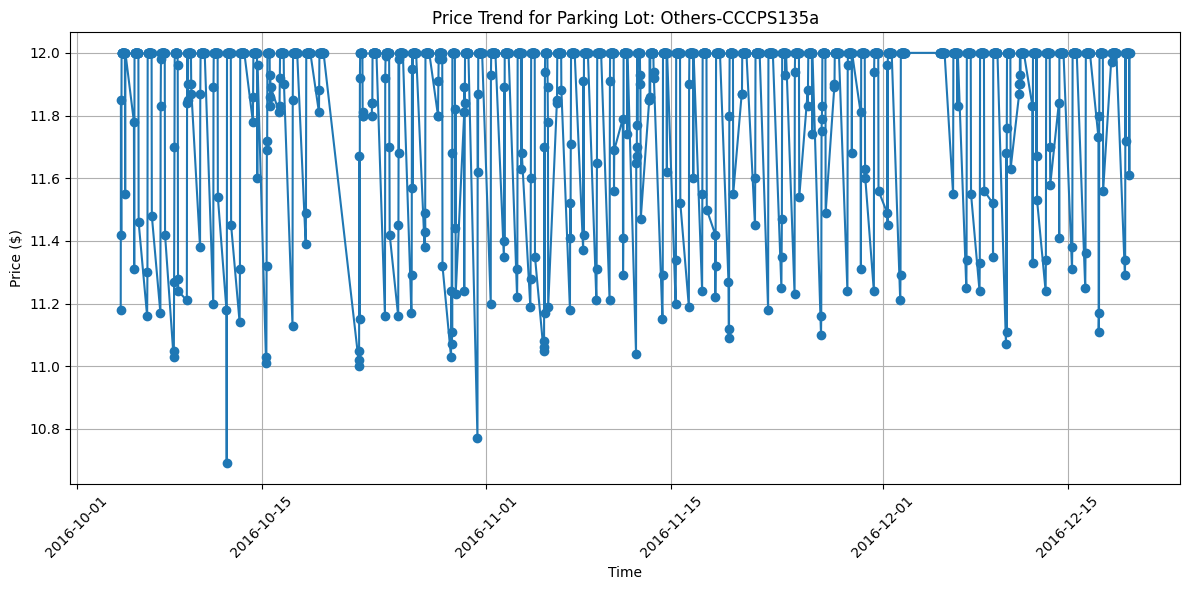

In [ ]:
import matplotlib.pyplot as plt

# Load the price output CSV
df_price = pd.read_csv("pricing_output.csv")

# Convert timestamp to datetime
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"])

# Sort by time
df_price = df_price.sort_values("timestamp")

# Plot price over time for a specific parking lot
lot_id_to_plot = df_price["lot_id"].unique()[0]  # or specify manually e.g. "BHMBCCMKT01"
lot_df = df_price[df_price["lot_id"] == lot_id_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(lot_df["timestamp"], lot_df["price"], marker='o', linestyle='-')
plt.title(f"Price Trend for Parking Lot: {lot_id_to_plot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
import pandas as pd
import time
import json
import os

output_notebook()

source = ColumnDataSource(data=dict(x=[], y=[]))

p = figure(x_axis_type='datetime', title="Real-Time Parking Prices", width=800, height=400)
p.line(x='x', y='y', source=source, line_width=2, color="blue")

handle = show(p, notebook_handle=True)

# Simulate loading from output JSON
while True:
    if os.path.exists("pricing_output.json"):
        with open("pricing_output.json", "r") as f:
            lines = f.readlines()[-20:]
            times, prices = [], []
            for line in lines:
                data = json.loads(line)
                times.append(pd.to_datetime(data['timestamp']))
                prices.append(data['price'])

            source.data = dict(x=times, y=prices)
            push_notebook(handle=handle)
    time.sleep(1)
# live map is not working because Google Colab doesn’t support push_notebook live updates

KeyboardInterrupt: 

live map is not working because Google Colab doesn’t support push_notebook live updates

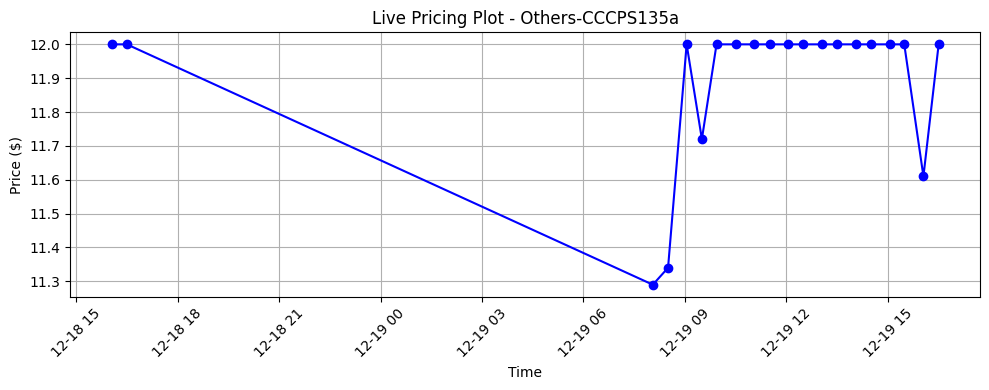

In [ ]:
#using alterntive matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

for _ in range(10):  # run for 10 seconds
    clear_output(wait=True)

    df = pd.read_csv("pricing_output.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp")

    lot_id = df["lot_id"].unique()[0]
    lot_df = df[df["lot_id"] == lot_id].tail(20)

    plt.figure(figsize=(10, 4))
    plt.plot(lot_df["timestamp"], lot_df["price"], marker="o", color="blue")
    plt.title(f"Live Pricing Plot - {lot_id}")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    time.sleep(1)


In [ ]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import pandas as pd
import time
import os

output_notebook()

# Initialize plot
source = ColumnDataSource(data=dict(x=[], y=[]))

p = figure(x_axis_type='datetime', title="Live Price Plot", width=800, height=400)
p.line(x='x', y='y', source=source, line_width=2, color="green")

handle = show(p, notebook_handle=True)

# Start timer
start = time.time()

while time.time() - start < 10:
    if not os.path.exists("pricing_output.csv"):
        print(" pricing_output.csv not found")
        time.sleep(1)
        continue

    try:
        df = pd.read_csv("pricing_output.csv")
        print(f" Loaded {len(df)} rows")
        print("Columns:", df.columns.tolist())

        # Ensure timestamp is datetime
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["timestamp", "price"])
        df = df.sort_values("timestamp")

        if df.empty:
            print(" Data is empty after cleaning")
            time.sleep(1)
            continue

        # Select first valid lot
        lot_id = df["lot_id"].unique()[0]
        lot_df = df[df["lot_id"] == lot_id].tail(20)

        if lot_df.empty:
            print(f" No data for lot {lot_id}")
            time.sleep(1)
            continue

        # Show on chart
        source.data = dict(x=lot_df["timestamp"], y=lot_df["price"])
        push_notebook(handle=handle)
        print(f"Updated plot for lot: {lot_id}")
    except Exception as e:
        print("Error while plotting:", e)

    time.sleep(1)
#this runs for 10 seconds to avoid the infinite process

 Loaded 18368 rows
Columns: ['lot_id', 'timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Latitude', 'Longitude', 'price', 'time', 'diff']
Updated plot for lot: Others-CCCPS135a
 Loaded 18368 rows
Columns: ['lot_id', 'timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Latitude', 'Longitude', 'price', 'time', 'diff']
Updated plot for lot: Others-CCCPS135a
 Loaded 18368 rows
Columns: ['lot_id', 'timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Latitude', 'Longitude', 'price', 'time', 'diff']
Updated plot for lot: Others-CCCPS135a
 Loaded 18368 rows
Columns: ['lot_id', 'timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Latitude', 'Longitude', 'price', 'time', 'diff']
Updated plot for lot: Others-CCCPS135a
 Loaded 18368 rows
Columns: ['lot_id', 'timestam

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

output_notebook()

# Load CSV
df = pd.read_csv("pricing_output.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Optional: filter one lot
lot_id = df["lot_id"].unique()[0]
lot_df = df[df["lot_id"] == lot_id]

# Prepare data
source = ColumnDataSource(data={
    "x": lot_df["timestamp"],
    "y": lot_df["price"]
})

# Plot
p = figure(x_axis_type='datetime', title=f"Price Trend for {lot_id}", width=800, height=400)
p.line("x", "y", source=source, line_width=2, color="green")

show(p)


In [ ]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource

output_notebook()

lot_df = df[df["lot_id"] == "Others-CCCPS135a"].sort_values("timestamp").tail(50)

source = ColumnDataSource(data={
    "x": lot_df["timestamp"],
    "y": lot_df["price"]
})

p = figure(x_axis_type='datetime', title="Final Price Snapshot", width=800, height=400)
p.line("x", "y", source=source, line_width=2, color="green")
show(p)


## Assumptions Made

- Vehicle Type Weights: car = 1.0, bike = 0.7, truck = 1.5
- Traffic Mapping: low = 1, medium = 2, high = 3
- Price is normalized between 0.5x to 2x of base price ($10)
- Demand is clipped between 0 and 1 for smooth pricing
